#🌸 Flower Species Classification Using CNN (Oxford Flowers Dataset)

### 📥Step 1: Unzip the file

In [8]:
import zipfile
import os

# Path to the uploaded zip file
zip_file_path = '/content/flower_dataset.zip'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/flower_dataset')

# Verify the files were extracted
extracted_files = os.listdir('/content/flower_dataset')
print(extracted_files)


['sample_submission.csv', 'cat_to_name.json', 'dataset', 'README.md']


In [13]:
import os

dataset_path = '/content/flower_dataset/dataset'
classes = os.listdir(dataset_path)
print(classes)


['valid', 'train', 'test']


### Step 2: Import Required Libraries
First, let's import the necessary libraries. We will be using TensorFlow and Keras for constructing the model, as well as libraries like NumPy and Matplotlib for data handling and visualization.

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import LeakyReLU

### 🧹Step 3: Setup Paths
Define the paths where your dataset and other required files are located.




In [14]:
base_path = '/content/flower_dataset/dataset'  # Path where your dataset is located
train_dir = os.path.join(base_path, 'train')
valid_dir = os.path.join(base_path, 'valid')
test_dir = os.path.join(base_path, 'test')

json_path = '/content/flower_dataset/cat_to_name.json'  # Path to the cat_to_name.json file


### Step 4: Load the cat_to_name Mapping
In this step, we load the cat_to_name.json file which maps the class IDs to the actual flower names.

In [15]:
with open(json_path, 'r') as f:
    cat_to_name = json.load(f)

# Optional: convert keys to int if needed
cat_to_name = {int(k): v for k, v in cat_to_name.items()}
print(cat_to_name)


{21: 'fire lily', 3: 'canterbury bells', 45: 'bolero deep blue', 1: 'pink primrose', 34: 'mexican aster', 27: 'prince of wales feathers', 7: 'moon orchid', 16: 'globe-flower', 25: 'grape hyacinth', 26: 'corn poppy', 79: 'toad lily', 39: 'siam tulip', 24: 'red ginger', 67: 'spring crocus', 35: 'alpine sea holly', 32: 'garden phlox', 10: 'globe thistle', 6: 'tiger lily', 93: 'ball moss', 33: 'love in the mist', 9: 'monkshood', 102: 'blackberry lily', 14: 'spear thistle', 19: 'balloon flower', 100: 'blanket flower', 13: 'king protea', 49: 'oxeye daisy', 15: 'yellow iris', 61: 'cautleya spicata', 31: 'carnation', 64: 'silverbush', 68: 'bearded iris', 63: 'black-eyed susan', 69: 'windflower', 62: 'japanese anemone', 20: 'giant white arum lily', 38: 'great masterwort', 4: 'sweet pea', 86: 'tree mallow', 101: 'trumpet creeper', 42: 'daffodil', 22: 'pincushion flower', 2: 'hard-leaved pocket orchid', 54: 'sunflower', 66: 'osteospermum', 70: 'tree poppy', 85: 'desert-rose', 99: 'bromelia', 87: 

### 📊Step 5: Data Preprocessing and Augmentation
Data augmentation helps in improving generalization and reducing overfitting. We apply several augmentations like rotation, zoom, horizontal flip, etc., to the training data. We only rescale the validation and test data to normalize the pixel values.



In [16]:
#Data Preprocessing and Augmentation
img_size = (224, 224)  # Resize all images to 224x224 pixels
batch_size = 32

# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale image pixel values to [0, 1]
    rotation_range=40,  # Random rotation from 0 to 40 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill missing pixels after transformations
)

# Data Augmentation for Validation Data (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Data Augmentation for Test Data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # Since this is a multi-class classification problem
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


### 🧠Step 6: Build the CNN Model
Now, we create a Convolutional Neural Network (CNN) for flower species classification. We include convolution layers for feature extraction, pooling layers for dimensionality reduction, and fully connected layers for classification. Additionally, we use different activation functions (ReLU, LeakyReLU, Softmax) and include dropout and L2 regularization to handle overfitting.

In [17]:
#Build the CNN Model
num_classes = train_generator.num_classes  # Number of classes in the dataset

model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.1)),
    layers.MaxPooling2D(2, 2),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Layer with Dropout and L2 Regularization
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output Layer with Softmax activation for multi-class classification
    layers.Dense(num_classes, activation='softmax')
])

# Model summary to check the architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │        52,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,448,422 (169.56 MB)

 Trainable params: 44,448,422 (169.56 MB)

 Non-trainable params: 0 (0.00 B)

### Step 7: Compile the Model
Now, we compile the model using categorical cross-entropy loss (since this is a multi-class classification problem) and an optimizer (Adam in this case).



In [18]:
#Compile the Model
optimizer = Adam(learning_rate=0.001)  # Adam optimizer

model.compile(
    loss='categorical_crossentropy',  # Multi-class cross-entropy loss
    optimizer=optimizer,
    metrics=['accuracy']  # Track accuracy during training
)


### Step 8: Define Callbacks
Callbacks like ReduceLROnPlateau and EarlyStopping help with learning rate adjustment and stopping the training early if the model starts overfitting.

In [19]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


### Step 9: Train the Model
Now, we train the model on the training data and validate it on the validation set. We will also plot the training history to observe how the accuracy and loss evolve during the training.

In [20]:
history = model.fit(
    train_generator,
    epochs=35,  # Set a reasonable number of epochs
    validation_data=valid_generator,
    callbacks=[early_stop, lr_reduction]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
205/205 ━━━━━━━━━━━━━━━━━━━━ 106s 477ms/step - accuracy: 0.0671 - loss: 4.8646 - val_accuracy: 0.1687 - val_loss: 3.7406 - learning_rate: 0.0010
Epoch 2/35
205/205 ━━━━━━━━━━━━━━━━━━━━ 91s 445ms/step - accuracy: 0.1866 - loss: 3.6943 - val_accuracy: 0.2311 - val_loss: 3.4661 - learning_rate: 0.0010
Epoch 3/35
205/205 ━━━━━━━━━━━━━━━━━━━━ 92s 447ms/step - accuracy: 0.2347 - loss: 3.4928 - val_accuracy: 0.2689 - val_loss: 3.2850 - learning_rate: 0.0010
Epoch 4/35
205/205 ━━━━━━━━━━━━━━━━━━━━ 140s 439ms/step - accuracy: 0.2927 - loss: 3.2875 - val_accuracy: 0.3203 - val_loss: 3.1730 - learning_rate: 0.0010
Epoch 5/35
205/205 ━━━━━━━━━━━━━━━━━━━━ 91s 441ms/step - accuracy: 0.3388 - loss: 3.1416 - val_accuracy: 0.3900 - val_loss: 3.0726 - learning_rate: 0.0010
Epoch 6/35
205/205 ━━━━━━━━━━━━━━━━━━━━ 90s 440ms/step - accuracy: 0.3420 - loss: 3.0908 - val_accuracy: 0.4046 - val_loss: 3.0071 - learning_rate: 0.0010
Epoch 7/35
205/205 ━━━━━━━━━━━━━━━━━━━━ 90s 440ms/step - accuracy: 0

In [23]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stop, lr_reduction]
)


Epoch 1/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 90s 441ms/step - accuracy: 0.6248 - loss: 1.9219 - val_accuracy: 0.6381 - val_loss: 2.0432 - learning_rate: 2.5000e-04
Epoch 2/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 96s 469ms/step - accuracy: 0.6472 - loss: 1.8276 - val_accuracy: 0.6112 - val_loss: 2.1416 - learning_rate: 2.5000e-04
Epoch 3/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 91s 444ms/step - accuracy: 0.6651 - loss: 1.7527 - val_accuracy: 0.6320 - val_loss: 2.0052 - learning_rate: 2.5000e-04
Epoch 4/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 92s 446ms/step - accuracy: 0.6622 - loss: 1.7187 - val_accuracy: 0.6394 - val_loss: 2.0015 - learning_rate: 2.5000e-04
Epoch 5/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 90s 437ms/step - accuracy: 0.6633 - loss: 1.7229 - val_accuracy: 0.6296 - val_loss: 2.0123 - learning_rate: 2.5000e-04
Epoch 6/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 89s 433ms/step - accuracy: 0.6799 - loss: 1.6464 - val_accuracy: 0.6222 - val_loss: 2.0135 - learning_rate: 2.5000e-04
Epoch 7/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 90s 43

In [24]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=[early_stop, lr_reduction]
)

Epoch 1/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 90s 440ms/step - accuracy: 0.7503 - loss: 1.2822 - val_accuracy: 0.6687 - val_loss: 1.8317 - learning_rate: 6.2500e-05
Epoch 2/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 91s 446ms/step - accuracy: 0.7474 - loss: 1.2905 - val_accuracy: 0.6687 - val_loss: 1.8325 - learning_rate: 6.2500e-05
Epoch 3/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 89s 435ms/step - accuracy: 0.7507 - loss: 1.2800 - val_accuracy: 0.6638 - val_loss: 1.8938 - learning_rate: 6.2500e-05
Epoch 4/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7498 - loss: 1.2811
Epoch 4: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
205/205 ━━━━━━━━━━━━━━━━━━━━ 88s 429ms/step - accuracy: 0.7498 - loss: 1.2810 - val_accuracy: 0.6601 - val_loss: 1.8627 - learning_rate: 6.2500e-05
Epoch 5/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 89s 436ms/step - accuracy: 0.7549 - loss: 1.2283 - val_accuracy: 0.6711 - val_loss: 1.8298 - learning_rate: 3.1250e-05
Epoch 6/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 89s 431ms/st

### Step 10: Transfer Learning
We'll use MobileNetV2 as the base model (you can change it to EfficientNet or others later if needed).

In [3]:
#Load Pretrained Model (Transfer Learning)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers


# Load MobileNetV2 base model (without top layers)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

#Add Custom Layers on Top
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Global pooling instead of flatten
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

# Final model
model1 = Model(inputs=base_model.input, outputs=output)
model1.summary()


NameError: name 'num_classes' is not defined

In [26]:
#Compile the Model
model1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)


In [27]:
#Train the Model
history1 = model1.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=[early_stop, lr_reduction]
)


Epoch 1/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 108s 474ms/step - accuracy: 0.0762 - loss: 4.4902 - val_accuracy: 0.4743 - val_loss: 2.4610 - learning_rate: 5.0000e-04
Epoch 2/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 89s 432ms/step - accuracy: 0.3575 - loss: 2.7222 - val_accuracy: 0.6748 - val_loss: 1.4068 - learning_rate: 5.0000e-04
Epoch 3/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 89s 435ms/step - accuracy: 0.5035 - loss: 1.9272 - val_accuracy: 0.7457 - val_loss: 1.0219 - learning_rate: 5.0000e-04
Epoch 4/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 89s 433ms/step - accuracy: 0.5690 - loss: 1.5813 - val_accuracy: 0.7885 - val_loss: 0.8445 - learning_rate: 5.0000e-04
Epoch 5/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 139s 418ms/step - accuracy: 0.6039 - loss: 1.3726 - val_accuracy: 0.7922 - val_loss: 0.7643 - learning_rate: 5.0000e-04
Epoch 6/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 86s 422ms/step - accuracy: 0.6631 - loss: 1.2138 - val_accuracy: 0.8105 - val_loss: 0.6897 - learning_rate: 5.0000e-04
Epoch 7/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 86s 

##### Fine tuning


In [1]:
# Unfreeze the base model
base_model.trainable = True

# Freeze all layers except the last N (e.g., 20)
fine_tune_at = len(base_model.layers) - 20

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


NameError: name 'base_model' is not defined

### 📈Step 11: Plotting the Training and Validation Accuracy/Loss


In [7]:
# Plotting the Training and Validation Accuracy/Loss
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

##### For CNN model

NameError: name 'history' is not defined

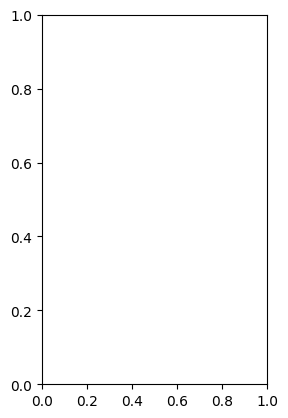

In [8]:
# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

##### For pretrained model

NameError: name 'history1' is not defined

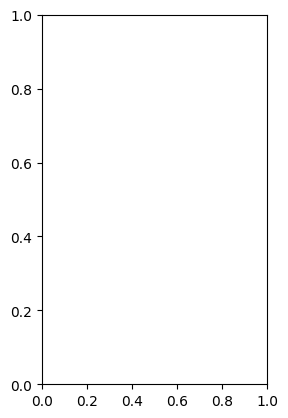

In [9]:
# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history1.history1['accuracy'], label='Train Accuracy')
plt.plot(history1.history1['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history1.history1['loss'], label='Train Loss')
plt.plot(history1.history1['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

### ✅Step 12: Prepare Test Predictions
In this step, we load the test data and predict the flower species using the trained model. We also prepare the final submission file (flower_submission.csv)

In [ ]:
# Step 9: Prepare Test Predictions
from tensorflow.keras.preprocessing import image

def preprocess_img(path):
    img = image.load_img(path, target_size=img_size)
    img = image.img_to_array(img) / 255.0
    return img

submission_csv_path = '/content/flower_dataset/sample_submission.csv'  # Path to sample_submission.csv file

submission_df = pd.read_csv(submission_csv_path)  # Load sample_submission.csv
test_image_paths = [os.path.join(test_dir, fname) for fname in submission_df['file_name']]
test_images = np.array([preprocess_img(p) for p in test_image_paths])

# Predict the test images
preds = model.predict(test_images)

# Convert predictions to flower ids and names
pred_indices = np.argmax(preds, axis=1)  # Get the index with the highest probability

# Map the indices back to flower ids
index_to_class = {v: k for k, v in train_generator.class_indices.items()}
submission_df['id'] = [index_to_class[idx] for idx in pred_indices]
submission_df['flower_name'] = [cat_to_name.get(int(idx), "Unknown") for idx in pred_indices]

# Save the submission file
submission_df.to_csv('flower_submission.csv', index=False)
submission_df.head()
